In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import monpa
import jieba.analyse
import codecs
import operator
import nltk

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


## 法一：先合併df再切成series再轉成list

In [2]:
covid19_china = pd.read_csv("./大趨勢-武漢肺炎 新冠肺炎 Covid-19 Delta Omicron流感/中時/COVID-19_cleaned 中時.csv", encoding = 'utf-8')
covid19_china.head()

,CATEGORY,TITLE,cleaned_text,FROM,TIME
0,0,史話》亞裔不再做啞裔（一）,史話 亞裔 啞裔 編按 底 新冠 疫情 全球 開始 流行 加上 美國 總統 激化 亞裔 仇視...,中時新聞網,2021-12-22 00:00:00
1,1,MLB》漢克阿倫施打新冠疫苗 呼籲大家跟進,MLB 漢克阿倫 施打 新冠 疫苗 呼籲 美國 職棒 傳奇 漢克阿倫 ( Hank Aaro...,中時新聞網,2021-01-06 11:02:38
2,2,轄區確診者最多 苗縣消防第2大隊全員打疫苗,轄區 確診 苗縣 消防 全 員 疫苗 苗栗縣 昨天 累計 名 武漢 肺炎 確診 均 消防局 ...,中時新聞網,2021-05-28 14:35:34
3,3,陳時中掛保證 500萬劑莫德納疫苗年中到貨,陳時中 掛 保證 劑 莫德納 疫苗 美國 莫德納公司 宣布 出售 劑 新冠 疫苗 台灣 衛福...,中時新聞網,2021-02-10 10:10:12
4,4,羅列謀獨三大罪狀 痛批難逃歷史審判 嗆算台獨總帳 陸官媒點名蘇揆,羅列謀 獨三 罪狀 痛批 難逃 歷史 審判 嗆 算 台獨 總帳 陸官媒 點名 蘇揆 機關報 ...,中時新聞網,2020-11-20 04:10:00


In [3]:
covid19_free = pd.read_csv("./大趨勢-武漢肺炎 新冠肺炎 Covid-19 Delta Omicron流感/自由/COVID-19_cleaned 自由.csv", encoding = 'utf-8')
covid19_free.head()

,CATEGORY,TITLE,cleaned_text,FROM,TIME
0,0,某國小赴蘭嶼校外教學1生確診107人困當地 新北市府稱協調東縣接回,國小 赴 蘭嶼 校 外 教學 生 確診 困當地 新北市府 稱 協調 東縣 接回 新北市 累計...,自由時報,2022-04-20 17:23:05
1,1,桃園新街國小昨增3確診 師生40天內二度採檢好無奈,桃園 新街 國小 昨 增 確診 師生 天 二 度 採檢 新街 國小 學童 確診 校方 緊急 ...,自由時報,2022-03-01 10:33:28
2,2,上海又一神操作！舉辦抗疫慶功晚會被罵翻 臨時取消,神 操作 舉辦 抗 疫慶功 晚會 罵 翻 取消 疫情 嚴重 實施 封控 民怨 四 美聯社 〔...,自由時報,2022-04-13 06:51:18
3,3,恐達33萬例！南韓連2天單日速增17萬確診,恐 達 例 南韓 天 單日 速增 確診 南韓 民眾 首爾 處 採檢站 排隊 篩檢 歐新社 〔...,自由時報,2022-02-24 09:47:04
4,4,單日1500例才啟動居家照護太慢 侯友宜：相信中央會盡快,單日 例 啟動 居家 太 慢 侯友宜 相信 新北 市長 侯友宜 呼籲 啟動 居家 醫療量 衝...,自由時報,2022-04-10 12:13:22


In [4]:
covid19_new = pd.concat([covid19_china, covid19_free], axis = 0)
covid19_new = covid19_new.drop("CATEGORY", axis = 1)
covid19_new = covid19_new.rename_axis('index').reset_index()
covid19_new = covid19_new.drop("index", axis = 1)
covid19_new

,TITLE,cleaned_text,FROM,TIME
0,史話》亞裔不再做啞裔（一）,史話 亞裔 啞裔 編按 底 新冠 疫情 全球 開始 流行 加上 美國 總統 激化 亞裔 仇視...,中時新聞網,2021-12-22 00:00:00
1,MLB》漢克阿倫施打新冠疫苗 呼籲大家跟進,MLB 漢克阿倫 施打 新冠 疫苗 呼籲 美國 職棒 傳奇 漢克阿倫 ( Hank Aaro...,中時新聞網,2021-01-06 11:02:38
2,轄區確診者最多 苗縣消防第2大隊全員打疫苗,轄區 確診 苗縣 消防 全 員 疫苗 苗栗縣 昨天 累計 名 武漢 肺炎 確診 均 消防局 ...,中時新聞網,2021-05-28 14:35:34
3,陳時中掛保證 500萬劑莫德納疫苗年中到貨,陳時中 掛 保證 劑 莫德納 疫苗 美國 莫德納公司 宣布 出售 劑 新冠 疫苗 台灣 衛福...,中時新聞網,2021-02-10 10:10:12
4,羅列謀獨三大罪狀 痛批難逃歷史審判 嗆算台獨總帳 陸官媒點名蘇揆,羅列謀 獨三 罪狀 痛批 難逃 歷史 審判 嗆 算 台獨 總帳 陸官媒 點名 蘇揆 機關報 ...,中時新聞網,2020-11-20 04:10:00
...,...,...,...,...
30605,謠言終結站》伊維菌素可以有效對抗Omicron變種病毒？,謠言 終結 站 伊維菌素 Omicron 變種 病毒 謠言 終結 站 網傳 消息 近日 社群...,自由時報,2022-02-06 05:30:00
30606,防疫情蔓延 Google要求美國員工每週篩檢,防疫情 蔓延 Google 美國 員工 週 篩檢 Google 進入 辦公室 員工 週 進行...,自由時報,2022-01-15 15:36:00
30607,元旦歐洲武肺累計確診破億例 外媒：占全球逾1/3,元旦 歐洲 武肺 累計 確診 破 億 例 外媒 占 全球 逾 武漢 肺炎 新型 冠狀 病毒病...,自由時報,2022-01-02 13:00:28
30608,神隱10天終於現身！英相強森：謹慎歡慶新年 快去打加強針,神隱 天 終於 現身 英相 強森 謹慎 歡慶 新年 快 加強 針 變種 病毒 Omicron...,自由時報,2021-12-29 23:26:11


## 法二：合併之後另存新檔再轉成list

In [ ]:
covid19_new.to_csv('./大趨勢-武漢肺炎 新冠肺炎 Covid-19 Delta Omicron流感/covid19.csv', header = True, index = False, encoding="utf-8")

In [ ]:
covid19 = pd.read_csv('./大趨勢-武漢肺炎 新冠肺炎 Covid-19 Delta Omicron流感/covid19.csv', encoding = 'utf-8')
covid19

In [5]:
covid19 = covid19_new['cleaned_text'].values.tolist()
type(covid19)

list

In [6]:
covid19[0]

'史話 亞裔 啞裔 編按 底 新冠 疫情 全球 開始 流行 加上 美國 總統 激化 亞裔 仇視 開始 升溫 作者 江青 新作 念念 親身 記錄 省思 疫情 反亞裔 情緒 書 出版 史話 專欄 節選 刊登 寫 紐約 旬 終於 排除 萬難 瑞典 回到 紐約 探望 歲 母親 身體 欠妥 急診 探望 前 晚 浴室 摔斷 根 肋骨 疼痛 難當 分離 月 聚有如隔世 擁抱 相視 微笑 天 母親 住處 陪 談 家常 煮 點 菜 調整 藥 周 血壓 開始 回復 正常 胃口 先前 精氣神 顯而易見 天 天 進步 青霞 微信 孝順 孝 疫情 孤寂 影響 精神 健康 狀況 親情 良藥 注意到 紐約 蕭條 關門 零 星星 客人 餐館 歇業 冷 清清 店舖 黑漆漆 辦公 空蕩蕩 燈火 熄滅 林肯 黑洞 頓時 心 空 塊 眼前 見 蘋果 ─ ─ 紐約 令 心碎 疫情 朋友 見面 電話 聊天 話題 接種 疫苗 亞裔 安全 問題 知情 注意 媒體 報導 瞭解 仇恨 亞裔 火苗 全 美國 燃燒 寫 篇 投訴 陪 媽媽 老人中心 早餐 莫名其妙 羞辱 番 節錄 片段 諾大 食堂 客滿 意識到 亞洲人 遠 男士 走 問 坐 點頭 早餐 談天 半 男士 突然 問 妳 點頭 妳 請 桌 嘰哩咕嚕 外國 話 完全 懂得 尊重 剛剛 歐洲 回來 媽媽 久 沒有 見 …… 回到 繼續 妳 懂 回到 美國 近 頭 聽到 蠻 講理 豈 話 美國 重要 … … 站起來 餐盤 弄得 通通響 甩 椅子 揚長 決定 老人中心 辦公室 投訴 促使 投訴 原因 感到 川普任 總統 明顯 感到 移民 難民 弱勢 群體 欺壓 社會 白人 美國 優先 類 口吻 現象 越 趨 嚴重 投訴 負責人 請教 『 美國 重要 』 句 話 什麼 意思 清楚 川普 支持者 川普 移民 政策 妳 知道 搞 分裂 現在 特別 重視 製造 分裂 尊重 扭曲 現象 絕不 容忍 姑且 歧視 敗類 愚昧 …… 負責人 振振有辭 理直氣壯 文章 句 告訴 負責人 美國 投訴 希望 目前 現象 願望 背道而馳 忍無可忍 投訴 演 變成 控訴 春天 疫情 開始 疫情 掀起 族主義 仇恨 源頭 美國 歷史 固有 部分 日 趨 嚴重 原因 民眾 美 激烈 競爭 前提 敵意 嫉恨 情緒 避免 加大 前 總統 川普火 澆油 場 疫情 武漢 病毒 功夫 流感 類 詛咒性 字眼

In [11]:
import nltk
all = []
word = []
stop_word=['表示','進行',')','(','記者','【', '】',"天","表示",'……','抽','天天中獎','報導','現在','活動', '〔', 
           '〕', '%', '％', '月', '沒','外', '未', '約', '元', '應', '新', '-', '國', '高', '歲', '全', '家', 
           '請', '例', '劑', '日', '名', '前', '案', '目前', '新增', '沒有', '出現', '相關', '持續', '工作', '結果',
          '接種', '指出', '施打', '提供', '接觸']
for i in range(len(covid19)):
    word = covid19[i].split(' ')
    for j in range(len(word)):
         if word[j] not in stop_word:
            all.append(word[j])
all

['史話',
 '亞裔',
 '啞裔',
 '編按',
 '底',
 '新冠',
 '疫情',
 '全球',
 '開始',
 '流行',
 '加上',
 '美國',
 '總統',
 '激化',
 '亞裔',
 '仇視',
 '開始',
 '升溫',
 '作者',
 '江青',
 '新作',
 '念念',
 '親身',
 '記錄',
 '省思',
 '疫情',
 '反亞裔',
 '情緒',
 '書',
 '出版',
 '史話',
 '專欄',
 '節選',
 '刊登',
 '寫',
 '紐約',
 '旬',
 '終於',
 '排除',
 '萬難',
 '瑞典',
 '回到',
 '紐約',
 '探望',
 '母親',
 '身體',
 '欠妥',
 '急診',
 '探望',
 '晚',
 '浴室',
 '摔斷',
 '根',
 '肋骨',
 '疼痛',
 '難當',
 '分離',
 '聚有如隔世',
 '擁抱',
 '相視',
 '微笑',
 '母親',
 '住處',
 '陪',
 '談',
 '家常',
 '煮',
 '點',
 '菜',
 '調整',
 '藥',
 '周',
 '血壓',
 '開始',
 '回復',
 '正常',
 '胃口',
 '先前',
 '精氣神',
 '顯而易見',
 '進步',
 '青霞',
 '微信',
 '孝順',
 '孝',
 '疫情',
 '孤寂',
 '影響',
 '精神',
 '健康',
 '狀況',
 '親情',
 '良藥',
 '注意到',
 '紐約',
 '蕭條',
 '關門',
 '零',
 '星星',
 '客人',
 '餐館',
 '歇業',
 '冷',
 '清清',
 '店舖',
 '黑漆漆',
 '辦公',
 '空蕩蕩',
 '燈火',
 '熄滅',
 '林肯',
 '黑洞',
 '頓時',
 '心',
 '空',
 '塊',
 '眼前',
 '見',
 '蘋果',
 '─',
 '─',
 '紐約',
 '令',
 '心碎',
 '疫情',
 '朋友',
 '見面',
 '電話',
 '聊天',
 '話題',
 '疫苗',
 '亞裔',
 '安全',
 '問題',
 '知情',
 '注意',
 '媒體',
 '瞭解',
 '仇恨',
 '亞裔',
 '火苗',
 '美國',
 '燃燒',
 '寫',
 '篇',


In [12]:
fdist = nltk.FreqDist(all)
fdist.most_common(30)

[('疫苗', 95686),
 ('疫情', 60400),
 ('確診', 42791),
 ('病毒', 35413),
 ('防疫', 31828),
 ('新冠', 26630),
 ('感染', 24457),
 ('民眾', 23537),
 ('肺炎', 21730),
 ('台灣', 21296),
 ('Omicron', 18603),
 ('美國', 18064),
 ('隔離', 16592),
 ('症狀', 14984),
 ('採檢', 14913),
 ('病例', 14906),
 ('Delta', 14878),
 ('指揮中心', 14749),
 ('口罩', 12914),
 ('政府', 12860),
 ('COVID', 12031),
 ('措施', 11979),
 ('風險', 11762),
 ('國家', 11158),
 ('全球', 11123),
 ('醫院', 11017),
 ('死亡', 9586),
 ('社區', 9461),
 ('流行', 9386),
 ('AZ', 9310)]

In [13]:
stopwords = {}.fromkeys([")","(","天","表示",'記者','抽','天天中獎','報導','現在','活動', '-', '未', '元', '沒', '點', '外', '約'])

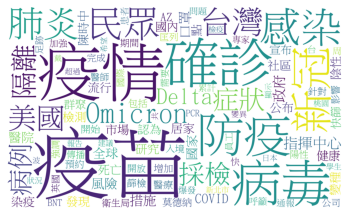

<Figure size 1000x600 with 0 Axes>

In [14]:
def generate_wordcloud(keywords, stopwords, file_path):
    wc = WordCloud(font_path = "./TW-Sung-98_1.ttf",
                   background_color = "white",
                   max_words = 100, stopwords = stopwords,
                   width=2000, height=1200)
    
    wc.generate_from_frequencies(keywords)
    plt.imshow(wc)
    plt.axis("off")
    plt.figure(figsize = (10, 6), dpi = 100)
    plt.show()
    wc.to_file('./文字雲/covid19.jpg')

# def get_keywords(file_path, topN):
#     keywords = {}
#     with open(file_path, "r", encoding = "utf-8") as f:
#         corpus = ""
#         for line in f:
#             corpus = f'{corpus}{" ".join(monpa.cut(line))}'
#         tags = jieba.analyse.extract_tags(corpus, topK = topN, withWeight = True)
#         for tag, weight in tags:
#             keywords[tag] = weight
#     return keywords

# keywords = get_keywords('./covid19.txt', 30)
# print(keywords)
x = generate_wordcloud(fdist, stopwords, "./covid19_wordcloud.jpg")

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import monpa
import jieba.analyse
import codecs
from glob import glob
import nltk

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


In [2]:
files = glob('./疫苗接種/中時/*_cleaned.csv')

df = pd.concat((pd.read_csv(file, usecols = ['cleaned_text'], dtype = {'cleaned_text':str})for file in files), ignore_index = True)

df = df['cleaned_text']
df

0        國際 社會 助 全球 抗疫 傳 拜登 政府 擬 追加 輝瑞 莫德納 疫苖 分送 繼 傳出 美...
1        輝瑞 疫苗 分鐘 敏 美 醫 護送 加護 病房 曝光 美國 輝瑞大 藥廠 Pfizer 開發...
2        英 開打 疫苗 盼 生活 回歸 常態 英國 率先 開打 美國 藥廠 輝瑞 Pfizer 德國...
3        目標 單日 劑 指揮中心 派 協助 接種 力 拚 劑 疫苗 覆蓋率 流行 疫情 指揮中心 開...
4        全民 劑 疫苗 FDA 專家 否決 美國 總統 拜登 全民 接種 加強 劑 計畫 踢到 鐵板...
                               ...                        
38559    陳曦快 評 專屬 標籤 貼 鴻海 台積電 成功 買到 劑 BNT 疫苗 民進黨 瘋狂 搶功 ...
38560    觀念 平台 － 牛 走虎 壬寅 投資 方向 校 準確 立 快 尾聲 送走 牛年 迎接 虎年 ...
38561    雲林 少婦 疫苗 哺乳 女嬰次 猝死 檢擇期 解剖 雲林縣 蘇姓 媽媽 昨天 施打 AZ 疫...
38562    金門莫德納 疫苗 明天 開打 楊鎮浯 視察 接種 站 金門 獲 配發 莫德納 疫苗 劑 ／ ...
38563    國民黨 控 衛福部 高端 效期 國民黨 立院黨團 昨 開 記者會 指 衛福 部長 陳時中 日...
Name: cleaned_text, Length: 38564, dtype: object

In [3]:
df = df.values.tolist()
df[0]

'國際 社會 助 全球 抗疫 傳 拜登 政府 擬 追加 輝瑞 莫德納 疫苖 分送 繼 傳出 美國 額外 採購 輝瑞 新冠 肺炎 疫苖 助 全 世界 抗疫 消息 透露 美國 政府 正在 莫德納 Moderna 展開 擴大 疫苖 採購 協商 消息 指出 拜登 政府 擬 未來 全球 近 家 捐贈 支 輝瑞 新冠 肺炎 疫苖 周三 輝瑞 股價 逆勢 收漲 % 帶動 莫德納 收 漲 % 發言人 表示 公司 意願 美國政府 提供 新冠 肺炎 疫苖 援助 低 收入 國家 拒絕 相關 協商 發表 評論 消息 透露 美國政府 莫德納 討論 結果 輝瑞 採購 數量 差不多 消息 指出 美國 低 收入 國家 非洲聯盟 African Union 分發 支 新冠 疫苗 明年 配送 支 消息 透露 美國 總統 拜登料 周四 七 工業國集團 G7 領袖 峰會 宣布 美國 採購 劑 輝瑞 -BioNTech 新冠 肺炎 疫苗 透過 全球 疫苖 取得 機制 Covax 分發 出去 預計 明年 捐贈 低 收入 國家 非洲聯盟 知情 表示 輝瑞 疫苖 部分 非 營利 價格 購買 美國 政府 莫德納 採購 疫苖 交易 條款 目前 尚'

In [ ]:
df[0]

In [4]:
files = glob('./疫苗接種/自由/*_cleaned.csv')

df_free = pd.concat((pd.read_csv(file, usecols = ['cleaned_text'], dtype = {'cleaned_text':str})for file in files), ignore_index = True)

df_free = df_free['cleaned_text']
df_free

0       武漢 肺炎 疫苗 開打 疾管署 APP 追蹤 事件 國內 開始 接種 武漢 肺炎 疫苗 疾管...
1       美國 逾 例 快 開打 輝瑞 疫苗 美國 聯邦政府 配發 批 輝瑞 疫苗 十四 日 送往 醫...
2       COVAX 分配 首 批 近 劑 AZ 疫苗 抵 台 陳時中 宣布 COVAX 平台 採購 ...
3       桃醫 快 明天 恢復 營運 BNT 稱 供 台灣 疫苗 陳時中 : 流行 疫情 指揮中心 指...
4       效益 風險 鍾飲文 心血管 高 患者 建議 疫苗 高醫大 附設 醫院 院長 鍾飲文 表示 心...
                              ...                        
2055    追求 清零 陳時中 現階段 社區 安全 防疫 策略 追求 清零 病毒 共存 陳時中今 表示 ...
2056    春節 班機 楊鎮浯 啟動 金門 機場 快篩 難度 疫情 嚴峻 金門 頻 聲音 反映 盼 機場...
2057    學測 日 登場 防疫 措施 學測 二十一日 登場 教育部 表示 級 警戒 期間 指考 高 防...
2058    高中職 校園 / 暫停 開放 禁止 外人 入校 疫情 升溫 盧秀燕 宣佈 二日 高中職 校園...
2059    富邦產 防疫 保單 停止 收件 明天 新 保單 富邦 產險 表示 基於 風險 政策 維持 公...
Name: cleaned_text, Length: 2060, dtype: object

In [5]:
df_free = df_free.values.tolist()
df_free[0]

'武漢 肺炎 疫苗 開打 疾管署 APP 追蹤 事件 國內 開始 接種 武漢 肺炎 疫苗 疾管署 參考 美國 作法 融入 居家 檢疫 關懷 概念 APP 監測 系統 雙向 簡訊 追蹤 接種 身體 狀況 圖 牛津 AZ 疫苗 路透 資料照 〔 〕 國內 開始 接種 武漢 肺炎 疫苗 偵測 接種 事件 疾管署 參考 美國 作法 融入 居家 檢疫 關懷 概念 Taiwan V-Watch APP 監測 系統 透過 雙向 簡訊 追蹤 接種 身體 狀況 批 牛津 AZ 疫苗 日 運抵 台灣 衛生 福利部 食品 藥物 進行 檢驗 封緘 截至 通過 項 檢驗 菌 試驗 合格 放行 提供 全 台 家 武漢 肺炎 冠狀 病毒 疾病 COVID - 責任 醫療院 高 風險 醫事 優先 接種 繼續 閱讀 ... 衛生 福利部 疾病管制署 武漢 肺炎線 研討會 疾管署 急性 傳染病組長 楊靖慧 透露 階段 接種 計畫 預計 啟動 屆時 醫事人員 預約 接種 名冊 勾稽 安排 接種 接種 疫苗 伴隨 事件 全球 關注 焦點 楊靖慧 避免 疫苗 事件 發生 建議 疫苗 民眾 避免 接種 醫院 須 設置 休息區 準備 急救 設備 接種 民眾 留在 現場 觀察 分鐘 流行 疫情 指揮中心 發言人 莊人祥 受 訪 未來 醫療院 遇到 接種 反應 事件 流感 疫苗 通報 食藥署 全 國 藥物 反應 通報 系統 通報 疾管署 疫苗 接種 事件 通報 系統 逐一 關懷 否 需要 通報 預防 接種 受害 救濟 接受 通報 疾管署 規劃 疫苗 取得 緊急 授權 EUA 持續 追蹤 接種 民眾體 抗體 狀況 副 作用 參考 美國 作法 設置 Taiwan V-Watch APP 關懷 居家 檢疫 模式 透過 雙向 簡訊 追蹤 前 名 接種 身體 狀況 持續 運用 科技 防疫 感染科 教授級 主治 醫師 黃玉成 表示 美國 早 疫苗 開始 接種 推出 V-Safe 系統 接種 主動 回報 事件 數百萬 名 美國 民眾 加入 通報 行列 根據 美國 統計 接種 劑 輝瑞 BNT 疫苗 發燒 約 % 劑 莫德納 發燒 約 % 未 監測到 疫苗 相關 反應 重症 症狀 反應 方面 BNT 接種 劑 約 莫德納 早期 百萬 劑 低 附設醫院 感染 副院長 黃高彬 接受 記者 電訪 聽到 海外 親友 分享 接種 疫苗 容易

In [6]:
df_free[0]

str

## 中時的去贅字與文字雲

In [6]:
import nltk
all_china = []
word = []
stop_word = ['%','...','〕','〔', '-', '助', '傳', '劑', '日', '歲', '％', '天', '前', '例', '新', '高', '全',
            ')', '沒', '(', '國', '周', '點', '僅', '快', '約', '台', '月', '名', '應', '未', '類', '請', '外',
            '家', '元', '先', '萬', '批', '元', '外', '先', '昨', '家', '期', '外', '目前', '現在', '認為', '顯示',
            '提供', '發現', '應該', '希望', '建議', '完成', '網友', '需要', '受', '表示']

for i in range(len(df)):
    word = df[i].split(' ')
    for j in range(len(word)):
         if word[j] not in stop_word:
            all_china.append(word[j])
all_china

['國際',
 '社會',
 '全球',
 '抗疫',
 '拜登',
 '政府',
 '擬',
 '追加',
 '輝瑞',
 '莫德納',
 '疫苖',
 '分送',
 '繼',
 '傳出',
 '美國',
 '額外',
 '採購',
 '輝瑞',
 '新冠',
 '肺炎',
 '疫苖',
 '世界',
 '抗疫',
 '消息',
 '透露',
 '美國',
 '政府',
 '正在',
 '莫德納',
 'Moderna',
 '展開',
 '擴大',
 '疫苖',
 '採購',
 '協商',
 '消息',
 '指出',
 '拜登',
 '政府',
 '擬',
 '未來',
 '全球',
 '近',
 '捐贈',
 '支',
 '輝瑞',
 '新冠',
 '肺炎',
 '疫苖',
 '周三',
 '輝瑞',
 '股價',
 '逆勢',
 '收漲',
 '帶動',
 '莫德納',
 '收',
 '漲',
 '發言人',
 '公司',
 '意願',
 '美國政府',
 '新冠',
 '肺炎',
 '疫苖',
 '援助',
 '低',
 '收入',
 '國家',
 '拒絕',
 '相關',
 '協商',
 '發表',
 '評論',
 '消息',
 '透露',
 '美國政府',
 '莫德納',
 '討論',
 '結果',
 '輝瑞',
 '採購',
 '數量',
 '差不多',
 '消息',
 '指出',
 '美國',
 '低',
 '收入',
 '國家',
 '非洲聯盟',
 'African',
 'Union',
 '分發',
 '支',
 '新冠',
 '疫苗',
 '明年',
 '配送',
 '支',
 '消息',
 '透露',
 '美國',
 '總統',
 '拜登料',
 '周四',
 '七',
 '工業國集團',
 'G7',
 '領袖',
 '峰會',
 '宣布',
 '美國',
 '採購',
 '輝瑞',
 '-BioNTech',
 '新冠',
 '肺炎',
 '疫苗',
 '透過',
 '全球',
 '疫苖',
 '取得',
 '機制',
 'Covax',
 '分發',
 '出去',
 '預計',
 '明年',
 '捐贈',
 '低',
 '收入',
 '國家',
 '非洲聯盟',
 '知情',
 '輝瑞',
 '疫苖',
 '部分',
 '非',


In [7]:
fdist = nltk.FreqDist(all_china)
fdist.most_common(30)

[('疫苗', 360153),
 ('接種', 112305),
 ('施打', 66597),
 ('疫情', 56902),
 ('台灣', 48350),
 ('AZ', 46901),
 ('民眾', 39194),
 ('高端', 38236),
 ('政府', 37745),
 ('莫德納', 37646),
 ('BNT', 37149),
 ('美國', 31616),
 ('新冠', 30404),
 ('病毒', 27567),
 ('防疫', 26948),
 ('預約', 25440),
 ('指出', 25392),
 ('沒有', 25202),
 ('指揮中心', 23015),
 ('陳時中', 21568),
 ('國家', 20775),
 ('開放', 18665),
 ('輝瑞', 16319),
 ('全球', 16270),
 ('國際', 16228),
 ('出現', 16005),
 ('採購', 15351),
 ('進行', 15168),
 ('感染', 14226),
 ('肺炎', 14017)]

In [9]:
stopwords = {}.fromkeys([")","(","●","+"])

In [17]:
import imageio.v2 as imagoio
back_color = imageio.imread('./KDL-60-1000.jpeg')

/var/folders/43/x96pj9hx1s7cfdnqf0g86k_m0000gn/T/ipykernel_11781/3466163229.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  back_color = imageio.imread('./KDL-60-1000.jpeg')


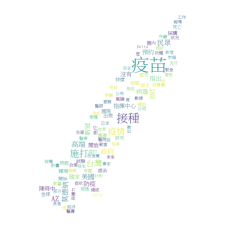

<Figure size 1000x600 with 0 Axes>

In [18]:
def generate_wordcloud(keywords, stopwords, file_path):
    wc = WordCloud(font_path = "./TW-Sung-98_1.ttf",
                   background_color = "white",
                   mask = back_color,
                   max_words = 100, stopwords = stopwords,
                   width=2000, height=1200)
    
    wc.generate_from_frequencies(keywords)
    plt.imshow(wc)
    plt.axis("off")
    plt.figure(figsize = (10, 6), dpi = 100)
    plt.show()
    wc.to_file('./文字雲/疫苗接種_中時_new.jpg')

generate_wordcloud(fdist, stopwords, "./selft_wordcloud1.jpg")

## 自由的去贅字與文字雲

In [19]:
all_free = []
word_free = []
stop_word = ['%','...','〔','〕', '-', 'APP', '圖', '批', '日', '項', '菌', '全', '台', '家', '劑', '／', '點',
            '歲', '現在', '請', '活動', '搶', '辦法', '保證', '抽', '閱讀', '表示', '新聞', '報導', '繼續', '相關',
            '提供', '目前', '預約', '記者', '目前', '指出', '掌握', '天天中獎', '例', '訊息', '前', '專區', '天', 
            '帶', '名', '國', '沒有', '約', '進行', '綜合', '出現', '％', '完成', '宣布', '高', '月', '未', '新', 
            '僅', '達', '資料', '快', '共', '昨', '站', '/', '昨天', '共', '站', '應','攝', '僅', '昨', '期', 
            '首', '攝', '首', '／', '達', '萬','首', '快', '天天', '站', '針對', '共', '僅', '昨', '資料', '完整',
            '持續', '期', '希望', '昨天', '元', '顯示', '問題', '公布', '/', '/', '達','快', '站', '共','應',
            '路透', '強調', '元', '開放', '攝','天天', '昨', '應', '顯示', '昨天', '/', '/', '／', '共', '達']

for i in range(len(df_free)):
    word_free = df_free[i].split(' ')
    for j in range(len(word_free)):
         if word_free[j] not in stop_word:
            all_free.append(word_free[j])
all_free

['武漢',
 '肺炎',
 '疫苗',
 '開打',
 '疾管署',
 '追蹤',
 '事件',
 '國內',
 '開始',
 '接種',
 '武漢',
 '肺炎',
 '疫苗',
 '疾管署',
 '參考',
 '美國',
 '作法',
 '融入',
 '居家',
 '檢疫',
 '關懷',
 '概念',
 '監測',
 '系統',
 '雙向',
 '簡訊',
 '追蹤',
 '接種',
 '身體',
 '狀況',
 '牛津',
 'AZ',
 '疫苗',
 '資料照',
 '國內',
 '開始',
 '接種',
 '武漢',
 '肺炎',
 '疫苗',
 '偵測',
 '接種',
 '事件',
 '疾管署',
 '參考',
 '美國',
 '作法',
 '融入',
 '居家',
 '檢疫',
 '關懷',
 '概念',
 'Taiwan',
 'V-Watch',
 '監測',
 '系統',
 '透過',
 '雙向',
 '簡訊',
 '追蹤',
 '接種',
 '身體',
 '狀況',
 '牛津',
 'AZ',
 '疫苗',
 '運抵',
 '台灣',
 '衛生',
 '福利部',
 '食品',
 '藥物',
 '檢驗',
 '封緘',
 '截至',
 '通過',
 '檢驗',
 '試驗',
 '合格',
 '放行',
 '武漢',
 '肺炎',
 '冠狀',
 '病毒',
 '疾病',
 'COVID',
 '責任',
 '醫療院',
 '風險',
 '醫事',
 '優先',
 '接種',
 '衛生',
 '福利部',
 '疾病管制署',
 '武漢',
 '肺炎線',
 '研討會',
 '疾管署',
 '急性',
 '傳染病組長',
 '楊靖慧',
 '透露',
 '階段',
 '接種',
 '計畫',
 '預計',
 '啟動',
 '屆時',
 '醫事人員',
 '接種',
 '名冊',
 '勾稽',
 '安排',
 '接種',
 '接種',
 '疫苗',
 '伴隨',
 '事件',
 '全球',
 '關注',
 '焦點',
 '楊靖慧',
 '避免',
 '疫苗',
 '事件',
 '發生',
 '建議',
 '疫苗',
 '民眾',
 '避免',
 '接種',
 '醫院',
 '須',
 '設置',
 '休息區',
 '準備',
 '急救',
 '

In [20]:
fdist = nltk.FreqDist(all_free)
fdist.most_common(30)

[('疫苗', 21205),
 ('接種', 8333),
 ('施打', 3612),
 ('AZ', 3140),
 ('肺炎', 3117),
 ('武漢', 3029),
 ('莫德納', 2763),
 ('疫情', 2361),
 ('BNT', 2203),
 ('美國', 2092),
 ('民眾', 2009),
 ('台灣', 1881),
 ('輝瑞', 1722),
 ('COVID', 1651),
 ('病毒', 1433),
 ('高端', 1428),
 ('指揮中心', 1378),
 ('政府', 1373),
 ('冠狀', 1212),
 ('防疫', 1133),
 ('國家', 1122),
 ('新型', 1067),
 ('確診', 1000),
 ('陳時中', 954),
 ('病毒病', 928),
 ('研究', 922),
 ('英國', 903),
 ('台北', 833),
 ('感染', 702),
 ('公司', 699)]

In [21]:
stopwords = {}.fromkeys([")","(","+"])

In [26]:
back_color = imageio.imread('./syringe_3ml_bd-2000x2000.jpeg')

/var/folders/43/x96pj9hx1s7cfdnqf0g86k_m0000gn/T/ipykernel_11781/2334856944.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  back_color = imageio.imread('./syringe_3ml_bd-2000x2000.jpeg')


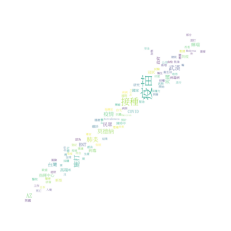

<Figure size 1000x600 with 0 Axes>

In [27]:
def generate_wordcloud(keywords, stopwords, file_path):
    wc = WordCloud(font_path = "./TW-Sung-98_1.ttf",
                   background_color = "white",
                   mask = back_color,
                   max_words = 100, stopwords = stopwords,
                   width=2000, height=1200)
    
    wc.generate_from_frequencies(keywords)
    plt.imshow(wc)
    plt.axis("off")
    plt.figure(figsize = (10, 6), dpi = 100)
    plt.show()
    wc.to_file('./文字雲/疫苗接種_自由_new.jpg')

x = generate_wordcloud(fdist, stopwords, "./selft_wordcloud1.jpg")

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import monpa
import jieba.analyse
import codecs
from glob import glob
import nltk

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


In [2]:
files = glob('./自主監測/中時新聞/*_cleaned.csv')

df_china = pd.concat((pd.read_csv(file, usecols = ['cleaned_text'], dtype = {'cleaned_text':str})for file in files), ignore_index = True)

df_china = df_china['cleaned_text']
df_china

0      朋友 確診 隔離 快篩 陽性 懶人 包 確診 急速 攀升 天 千 例確診 感染 Omicro...
1      竹市 ＋ 匡列 居隔 外縣市 足跡 重疊 新竹市 日 新增 名 確診 例 受 匡列 採檢 居...
2      職場 健保 快易通 PCR 輕鬆 查 企業 快篩 檢測 護 員工 徵 出門 健保 資訊 抓 ...
3      免費 PCR 快篩劑 快 全 台 新冠 肺炎 疫情 持續 擴大 確診 掌握 全 台 免費 P...
4      Omicron 春節 恐 侵 台 台 全 防疫 寶 少為 防範 Omicron 變異株 流行...
                             ...                        
748    汽車 百貨業 跨 足 賣 防疫 保健品 汽車 百貨 業者 抗 疫 維繫 營運 拓展 業務 焦...
749    開學 長庚科大 送 新生 快篩 試劑 開學 長庚科技大學 送給 新生 健康 關懷禮 包含 快...
750    新北市 議員 江怡臻 媒合 生技 公司 助 弱勢 捐贈 劑 居家 快篩 試劑 級 警戒 持續...
751    桃園 供 劑 快 篩 雇用 移工 單位 基層 診所 發放 劑 遠雄 貿港區 疫情 擴大 近期...
752    收假 倒數 開工 須 持 陰性 證明 桃園藥局 快 篩試劑 銷量 成長 農曆 春節 長達 天...
Name: cleaned_text, Length: 753, dtype: object

In [3]:
df_china = df_china.values.tolist()
df_china[0]

'朋友 確診 隔離 快篩 陽性 懶人 包 確診 急速 攀升 天 千 例確診 感染 Omicron 變異 株 逾 % 症狀 輕症 指揮中心 防疫 減災 減少 輕症 家 分流 措施 象徵 疫情 步入 模 染疫 階段 民眾 朋友 確診 快篩 陽性 隔離 問題 高度 關注 朋友 確診 隔離 指揮中心 表示 獲得 衛生 單位 通知 指示 前 先 留在 家 隔離 症狀 求助 密切 接觸 匡列 隔離 標準 前 天 隔離 前 面對面 接觸 超過 分鐘 快篩 陽性 民眾 器材 包好 帶去 社區 採檢站 PCR 核酸 檢測 勿 搭 交通 工具 快篩 陰性 包好 丟棄 整理 相關 項 防疫 資訊 供 民眾 參考 朋友 身邊 確診 密切 接觸 請 先 留在 家 戴 口罩 隔離 避免 共餐 接觸 特別 老人 衛生 單位 通知 指示 出現 發燒 喉嚨 痛 腹瀉 嗅 味覺 異常 症狀 聯繫 衛生局 撥打 密切 接觸 請 健康 監測 天 期間 疑似 症狀 請 戴 口罩 社區 採檢站 採檢 算是 密切 接觸 匡列 確診 發病 前 天 隔離 前 確診 面對 面 接觸 分鐘 算 密切 接觸 列為 居家 隔離 沒有 直接 接觸到 確診者 匡列 太太 確診 匡列 居家 隔離 檢測 居家 隔離 天數 天 確診 接觸 日 隔 天 算 天 隔離 期滿 前 檢驗 陰性 解除 隔離 天 繼續 健康 天 隔離 期間 天 健康 天 公費 家用 快篩 試劑 檢測 共 外面 接到 衛生 單位 通知 匡 列為 居家 隔離 接到 電話 通知 立即 生效 須 開車 騎車 步行 返家 隔離 禁止 搭乘 運輸 工具 全程 佩戴 口罩 回不了 家者 衛生局 電話 安排 防疫 車輛 ● 診者 足跡 重疊 收到 簡訊 辦 收到 細胞 簡訊 匡列 提醒 民眾 健康 監測 採檢站 公費 採檢 喉嚨 痛 症狀 速 採檢 健康 監測 期間 避免 出入 眾多 參加 活動 外出 必須 外出 應 全程 戴 口罩 完全 沒有 出現 症狀 正常 生活 ● 什麼 情況 快篩 住 確診數較多 呼吸道 症狀 確診者 足跡 熱區 確診者 接觸 史等 情況 建議 居家 快篩 ● 快篩 陽性 辦 居家 隔離 快篩 陽性 立即 聯絡 衛生局 防疫 專線 指示 處理 快篩 陽性 先 檢測 器材 密封 帶到 社區 採檢站 進一步 PCR 檢測 勿 搭乘 交通 工具 快篩 陰性

In [18]:
df_china[9]

'黃偉哲 ＋ 翻盤 鼓勵 民眾 居家 快篩 台南市 維持 天 + 厝 高雄 天 暴增 例 市長 黃偉哲 面對 疫情 放鬆 零確 診到 翻盤 居家 快 篩 試劑 開賣 鼓勵 市民 居家 快篩 強調 普遍 施打 疫苗 前 快篩 權宜 計 衛生局長 許以霖 持續 擴大 接種 疫苗 擬 推行 台南 歐美 居家 快篩 普及化 端午 跨 縣市 移動 產生 隱形 傳播 鏈 未 知 台北 農產運銷公司 群聚 感染 事件 擴大 需 密切 觀察 呼籲 移動 縣市 少 少 免 免 黃偉哲 鼓勵 民眾 居家 快篩 外面 暴露 排隊 居家 快篩 疫苗 尚未 全面 施打 快篩 失為 權宜 計 全球 疫情 急遽 升溫 歐美 國 疫情 開放 民眾 居家 快篩 避免 醫院 增加 群聚 目前 超商 買到 快篩 試 劑 擬 計畫 推廣 市民 養成 快篩 習慣 許以霖 目前 國人 接種 疫苗 覆蓋率 低 算 疫苗 代表 疫情 消失 歐美 民眾 普遍 習慣 居家 快篩 南市 方向 推廣 台南市 目前 天 篩檢 約 省下 部分 篩檢 醫療 成本 疫情 長期 抗戰 緊繃 醫護 量能 絕對 昨 公布 例 確診者 足跡 台南 高雄市 案 案 台南 醫院 停留 永康區 俗俗 賣 生鮮 超市 分鐘 屏東 案 日 度 佳里區 法旨宮 問事 宮廟 禁止 入內 男子 短暫 停留 匡列 廟方 友人 共 採檢 皆 陰性 昨 新增 例 疑 接種 AZ 疫苗 反應 住 護理 家 分別 慢性 病史 歲 女性 日 接種 日 喘 氣 送醫 治療 歲 慢性 肺 阻塞 病變 婦人 日 接種 日 呼吸 急促 送醫 治療 歲 失智 長期 臥床婦 日 接種 日 例 通報 台南 截至 昨日 接種 疫苗 死亡 共 例'

In [4]:
files = glob('./自主監測/自由新聞/*_cleaned.csv')

df_free = pd.concat((pd.read_csv(file, usecols = ['cleaned_text'], dtype = {'cleaned_text':str})for file in files), ignore_index = True)

df_free = df_free['cleaned_text']
df_free

0      高雄市 + 陳其邁 宣布 強化 防疫 措施 國內 疫情 升溫 高雄市 針對 四 國營 事業 ...
1      竹縣 + 明新科大 新湖 國小 停課 新竹 縣府 防疫 清消 高 風險 場所 竹縣府 提供 ...
2      強化 社區 監測 增加 定點 診所 發放 公費 快篩試劑 家用 快篩試劑 定點 診所 採檢院...
3      泰安 民宿 老闆 確診 苗 縣府 匡列 公布 足跡 清消 苗栗縣 新增 確診 足跡 遍及 尚...
4      藍委 質疑 普篩 陳時中 外國 疫情 趨緩 非 篩檢 疫苗 立法院 邀請 行政院長 蘇貞昌 ...
                             ...                        
555    北市 警文山一分局 確診 安排 全 局 快篩 北市 文山一分局 群聚 感染 擴大 陽性 確診...
556    基隆 全民 防疫 愛心 篩檢 首日 發 劑 基隆市 全民 防疫 愛心 篩檢 率先 仁愛區 開...
557    全 國 首 基隆 實施 類 普篩 市民 檢測 ／ 指揮中心 提供 家用 快篩 週 結果 出爐...
558    武肺 口服藥 庫存 充足 快篩 試劑 降價 醫師 公會 全聯會 理事長 柯富揚 表示 十八 ...
559    藍智庫 諷 蔡 政府 防疫 沒 超前 國民黨 智庫國家 政策 研究基金會 執行長 柯志恩 質...
Name: cleaned_text, Length: 560, dtype: object

In [5]:
df_free = df_free.values.tolist()
df_free[0]

'高雄市 + 陳其邁 宣布 強化 防疫 措施 國內 疫情 升溫 高雄市 針對 四 國營 事業 台電 台船 紅區 祭出 強化 防疫 措施 高雄市 衛生局 提供 〔 記者 葛祐豪 ／ 高雄 報導 〕 國內 疫情 升溫 高雄 前鎮區 化工廠 群聚 感染 增 例 累計 達 例 高雄 市長 陳其邁 強調 目前 社區 傳染 風險 應 檢疫 措施 調整 針對 防疫 旅館 線 工作 四 國營 事業 台船 紅區 祭出 強化 防疫 措施 陳其邁 防疫 記者會 表示 高雄 新增 確診 均 隔離 期間 陰轉陽 匡列 隔離 期間 採檢 確診 社區 傳播 風險 請 繼續 閱讀 ... 陳其邁 化工廠 群聚 感染 指標 發病 日 日 確診 傳給 密閉 空間 通風 共餐 情況 採 圈 匡列 星期五 接下來 匡列 隔離 發病 指出 病毒株 BA . 沒 包括 入境 % 漏出 防疫 旅館 風險 港口 感染 排除 高雄 群聚 感染源 陳其邁 強調 應 檢疫 措施 調整 面對 新 狀況 參酌 基隆 桃園 採取 加嚴 措施 特定 娛樂 場所 劑 規定 相同 陳其邁 宣布 高雄市 加強 防疫 措施 防疫 旅館 線 工作 週 應 居家 快篩 公費 提供 四 國營 事業 台電 台船 紅區 週三 快篩 捷運 國營 事業 重大 公共 工程 家 關鍵 產業 住宿 週 完成 快篩 集 合式 住宿 員工 含 國 外籍 特殊 情況 應 完成 劑 疫苗 接種 加工 出口區 工業區 關鍵 產業 工廠 應 落實 防疫 計畫 強化 餐廳 宿舍 交通車 防疫 前鎮 仁愛 公園 設立 社區 篩檢站 : - : : - : : - : : - : : - : : - : : - : : - : 確診 足跡 重疊 接觸史 民眾 請 攜帶 健保卡 前往 篩檢 武漢 肺炎 專區 請 點 相關 訊息 帶 掌握 抽 搶 現在 APP 新聞 保證 天天中獎 點 APP 活動 辦法'

In [4]:
df_free[2]

'強化 社區 監測 增加 定點 診所 發放 公費 快篩試劑 家用 快篩試劑 定點 診所 採檢院所 圖 指揮中心 提供 〔 記者 邱芷柔 ／ 台北 報導 〕 疫情 新增數 場域 感染 源待 釐清 群聚 事件 強化 社區 監測 流行 疫情 指揮中心 發言人 莊人祥今 日 宣布 協助 發放 公費 COVID - 家用 快篩 試劑 定點 目前 家 增加 家 基層 定點 診所 衛生所 發放點 衛生 福利部 疾病管制署 全球 資訊網 COVID - 防疫 專區 查詢 呼籲 需求 民眾 善加 利用 提醒 COVID - 症狀 感冒 相似 民眾 出現 呼吸道 症狀 加 前往 定點 診所 醫師 評估 發放 試劑 居家 檢驗 回報 快篩 結果 居家 快篩 檢驗 陽性 請 勿 慌張 儘速 鄰近 指定 社區 採檢院所 進 PCR 檢驗 繼續 閱讀 ... 公費 家用 快篩試劑 發放 診所 核酸 檢驗 指定 機構 資訊 衛生福利部 疾病 全球 資訊網 COVID - 防疫 專區 臺灣 社交 App 採檢 / 發放 公費 COVID - 家用 快篩試劑 社區 定點 診所 COVID - 全 國 指定 社區 採檢院所 查詢 感染 病毒 高 診數 區域 確診 足跡 熱區 確診者 接觸史 眾多 確 診者 足跡 重疊 民眾 覺 風險 出現 呼吸道 症狀 請 佩戴 醫 口罩 前往 掛號 醫師 評估 發放 試劑 檢驗 COVID - 家用 快篩 試劑 醫療 器材 販賣 業者 藥粧店 醫療 器材行 便利商店 藥局 購買 提醒 民眾 購買 請 確認 產品 名稱 家用 包裝 刊載 防疫 專案 核准 製造 X XXXXXXXX X 號 防疫 專案 核准 輸入 X X XXXXX XX X 號 字樣 產品 效期 期間 保存 期限 操作 影片 進行 採檢 操作 家用 快篩試劑 疑問 請 洽 原 購買 產品 醫療 器材商 藥局 逕 洽試劑 廠商 表示 COVID - 家 快 篩試劑 產品 核准 名單 產品 操作 影片 相關 資料 均 食藥署 網站 家 新型 冠狀 病毒 檢驗 試劑 專區 查詢 武漢 肺炎 專區 請 點 相關 訊息 帶 掌握 抽 搶 現在 APP 新聞 保證 天天 點 APP 活動 辦法'

## 中時的去贅字與文字雲

In [18]:
import nltk
all = []
word = []
stop_word=[')','(', '％', '款', '國', '未', '新', '名', '請', '外', '台', '需', '約', '應', '日', '進行', '指出',
           '-', '月', '先', '前', '高', '全', '家', '天', '劑', '元', '類', '達', '表示', '快', '提供', '篩試劑',
          '結果', '目前', '例', '相關', '相關', '公司', '沒', '沒有', '需要', '快速', '接種', '核准', '發放', '宣布',
          '希望', '協助', '市場', '計畫', '販售', '針對', '施打', '呼籲', '出現', '工作', '業者', '申請', '建議', 
          '強調', '進口', '昨', '週']

for i in range(len(df_china)):
    word = df_china[i].split(' ')
    for j in range(len(word)):
         if word[j] not in stop_word:
            all.append(word[j])
all

['朋友',
 '確診',
 '隔離',
 '快篩',
 '陽性',
 '懶人',
 '包',
 '確診',
 '急速',
 '攀升',
 '千',
 '例確診',
 '感染',
 'Omicron',
 '變異',
 '株',
 '逾',
 '%',
 '症狀',
 '輕症',
 '指揮中心',
 '防疫',
 '減災',
 '減少',
 '輕症',
 '分流',
 '措施',
 '象徵',
 '疫情',
 '步入',
 '模',
 '染疫',
 '階段',
 '民眾',
 '朋友',
 '確診',
 '快篩',
 '陽性',
 '隔離',
 '問題',
 '高度',
 '關注',
 '朋友',
 '確診',
 '隔離',
 '指揮中心',
 '獲得',
 '衛生',
 '單位',
 '通知',
 '指示',
 '留在',
 '隔離',
 '症狀',
 '求助',
 '密切',
 '接觸',
 '匡列',
 '隔離',
 '標準',
 '隔離',
 '面對面',
 '接觸',
 '超過',
 '分鐘',
 '快篩',
 '陽性',
 '民眾',
 '器材',
 '包好',
 '帶去',
 '社區',
 '採檢站',
 'PCR',
 '核酸',
 '檢測',
 '勿',
 '搭',
 '交通',
 '工具',
 '快篩',
 '陰性',
 '包好',
 '丟棄',
 '整理',
 '項',
 '防疫',
 '資訊',
 '供',
 '民眾',
 '參考',
 '朋友',
 '身邊',
 '確診',
 '密切',
 '接觸',
 '留在',
 '戴',
 '口罩',
 '隔離',
 '避免',
 '共餐',
 '接觸',
 '特別',
 '老人',
 '衛生',
 '單位',
 '通知',
 '指示',
 '發燒',
 '喉嚨',
 '痛',
 '腹瀉',
 '嗅',
 '味覺',
 '異常',
 '症狀',
 '聯繫',
 '衛生局',
 '撥打',
 '密切',
 '接觸',
 '健康',
 '監測',
 '期間',
 '疑似',
 '症狀',
 '戴',
 '口罩',
 '社區',
 '採檢站',
 '採檢',
 '算是',
 '密切',
 '接觸',
 '匡列',
 '確診',
 '發病',
 '隔離',
 '確診',
 '面對',
 '面',
 '接觸',

In [19]:
fdist = nltk.FreqDist(all)
fdist.most_common(100)

[('快篩', 4048),
 ('試劑', 2005),
 ('疫情', 1463),
 ('防疫', 1294),
 ('民眾', 1242),
 ('居家', 1113),
 ('檢測', 1001),
 ('篩檢', 944),
 ('疫苗', 803),
 ('病毒', 745),
 ('政府', 712),
 ('確診', 679),
 ('台灣', 624),
 ('企業', 609),
 ('PCR', 581),
 ('採檢', 572),
 ('指揮中心', 532),
 ('新冠', 528),
 ('抗原', 528),
 ('社區', 512),
 ('陽性', 468),
 ('陳時中', 446),
 ('家用', 429),
 ('價格', 399),
 ('檢驗', 388),
 ('醫療', 385),
 ('國內', 374),
 ('感染', 363),
 ('症狀', 360),
 ('陰性', 339),
 ('快篩試劑', 331),
 ('風險', 330),
 ('隔離', 327),
 ('醫院', 321),
 ('健康', 315),
 ('持續', 310),
 ('普篩', 305),
 ('肺炎', 304),
 ('開放', 300),
 ('需求', 297),
 ('產品', 297),
 ('員工', 293),
 ('廠商', 283),
 ('口罩', 275),
 ('購買', 272),
 ('措施', 242),
 ('核酸', 239),
 ('市府', 237),
 ('基隆', 225),
 ('快篩劑', 223),
 ('桃園', 211),
 ('美國', 211),
 ('衛生局', 205),
 ('專案', 205),
 ('流行', 203),
 ('接觸', 202),
 ('執行', 201),
 ('免費', 199),
 ('未來', 195),
 ('包括', 195),
 ('新增', 194),
 ('方式', 194),
 ('捐贈', 193),
 ('完成', 192),
 ('公布', 190),
 ('群聚', 190),
 ('取得', 190),
 ('公費', 189),
 ('擴大', 187),
 ('單位', 186),
 ('透過

In [20]:
stopwords = {}.fromkeys(["『","』","【","】","（", "）", '%', "●", "+", "/", "-"])

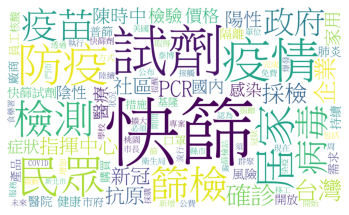

<Figure size 1000x600 with 0 Axes>

In [21]:
def generate_wordcloud(keywords, stopwords, file_path):
    wc = WordCloud(font_path = "./TW-Sung-98_1.ttf",
                   background_color = "white",
                   max_words = 100, stopwords = stopwords,
                   width=2000, height=1200)
    wc.generate_from_frequencies(keywords)
    plt.imshow(wc)
    plt.axis("off")
    plt.figure(figsize = (10, 6), dpi = 100)
    plt.show()
    wc.to_file('./文字雲/自主監測_中時.jpg')

# def get_keywords(file_path, topN):
#     keywords = {}
#     with open(file_path, "r", encoding = "utf-8") as f:
#         corpus = ""
#         for line in f:
#             corpus = f'{corpus}{" ".join(monpa.cut(line))}'
#         tags = jieba.analyse.extract_tags(corpus, topK = topN, withWeight = True)
#         for tag, weight in tags:
#             keywords[tag] = weight
#     return keywords

# keywords = get_keywords('./selft.txt', 30)
# print(keywords)
generate_wordcloud(fdist, stopwords, "./selft_wordcloud1.jpg")

## 自由的去贅字與文字雲

In [38]:
all_free = []
word_free = []
stop_word=['表示','進行',')','(','記者','天', '專區','抽','天天中獎','報導','現在','活動', '點', 'APP', '日', '提供',
           '相關', '請', '+', '四', '〔', '〕', '/', '增', '例', '例', '增', '應', '線', '四', '均', '...',
           '案', '劑', '搶', '-', '／', '快', '家', '全', '名', '須', '高', '未', '校', '歲', '帶', '昨', '共',
           '外', '繼續', '閱讀', '辦法', '圖', '攝', '元', '天天', '值', '週', '％', '%', '站']

for i in range(len(df_free)):
    word_free = df_free[i].split(' ')
    for j in range(len(word_free)):
         if word_free[j] not in stop_word:
            all_free.append(word_free[j])
all_free

['高雄市',
 '陳其邁',
 '宣布',
 '強化',
 '防疫',
 '措施',
 '國內',
 '疫情',
 '升溫',
 '高雄市',
 '針對',
 '國營',
 '事業',
 '台電',
 '台船',
 '紅區',
 '祭出',
 '強化',
 '防疫',
 '措施',
 '高雄市',
 '衛生局',
 '葛祐豪',
 '高雄',
 '國內',
 '疫情',
 '升溫',
 '高雄',
 '前鎮區',
 '化工廠',
 '群聚',
 '感染',
 '累計',
 '達',
 '高雄',
 '市長',
 '陳其邁',
 '強調',
 '目前',
 '社區',
 '傳染',
 '風險',
 '檢疫',
 '措施',
 '調整',
 '針對',
 '防疫',
 '旅館',
 '工作',
 '國營',
 '事業',
 '台船',
 '紅區',
 '祭出',
 '強化',
 '防疫',
 '措施',
 '陳其邁',
 '防疫',
 '記者會',
 '高雄',
 '新增',
 '確診',
 '隔離',
 '期間',
 '陰轉陽',
 '匡列',
 '隔離',
 '期間',
 '採檢',
 '確診',
 '社區',
 '傳播',
 '風險',
 '陳其邁',
 '化工廠',
 '群聚',
 '感染',
 '指標',
 '發病',
 '確診',
 '傳給',
 '密閉',
 '空間',
 '通風',
 '共餐',
 '情況',
 '採',
 '圈',
 '匡列',
 '星期五',
 '接下來',
 '匡列',
 '隔離',
 '發病',
 '指出',
 '病毒株',
 'BA',
 '.',
 '沒',
 '包括',
 '入境',
 '漏出',
 '防疫',
 '旅館',
 '風險',
 '港口',
 '感染',
 '排除',
 '高雄',
 '群聚',
 '感染源',
 '陳其邁',
 '強調',
 '檢疫',
 '措施',
 '調整',
 '面對',
 '新',
 '狀況',
 '參酌',
 '基隆',
 '桃園',
 '採取',
 '加嚴',
 '措施',
 '特定',
 '娛樂',
 '場所',
 '規定',
 '相同',
 '陳其邁',
 '宣布',
 '高雄市',
 '加強',
 '防疫',
 '措施',
 '防疫',
 '旅館',
 '工作',
 '居家'

In [40]:
fdist = nltk.FreqDist(all_free)
fdist.most_common(100)

[('快篩', 2040),
 ('確診', 1258),
 ('防疫', 1197),
 ('居家', 1061),
 ('疫情', 990),
 ('疫苗', 904),
 ('試劑', 819),
 ('民眾', 811),
 ('採檢', 729),
 ('篩檢', 690),
 ('新聞', 630),
 ('肺炎', 608),
 ('接種', 594),
 ('武漢', 569),
 ('保證', 567),
 ('PCR', 538),
 ('足跡', 524),
 ('衛生局', 496),
 ('社區', 475),
 ('檢測', 457),
 ('隔離', 452),
 ('陰性', 439),
 ('匡列', 432),
 ('目前', 428),
 ('市府', 421),
 ('陽性', 413),
 ('症狀', 398),
 ('新增', 392),
 ('結果', 381),
 ('掌握', 380),
 ('指揮中心', 376),
 ('台南', 375),
 ('COVID', 368),
 ('健康', 363),
 ('感染', 344),
 ('前', 343),
 ('政府', 336),
 ('接觸', 327),
 ('訊息', 325),
 ('員工', 320),
 ('醫院', 318),
 ('措施', 311),
 ('病毒', 311),
 ('指出', 295),
 ('台北', 288),
 ('口罩', 287),
 ('風險', 283),
 ('昨天', 277),
 ('完成', 273),
 ('學生', 273),
 ('公布', 271),
 ('工作', 268),
 ('開放', 267),
 ('市長', 252),
 ('出現', 245),
 ('施打', 243),
 ('針對', 241),
 ('持續', 241),
 ('群聚', 237),
 ('期間', 237),
 ('檢驗', 237),
 ('前往', 235),
 ('沒有', 231),
 ('高雄', 228),
 ('包括', 228),
 ('篩檢站', 222),
 ('篩試劑', 222),
 ('陳時中', 221),
 ('縣府', 216),
 ('冠狀', 210),
 ('呼籲',

In [29]:
stopwords = {}.fromkeys(["『","』","【","】","（", "）", '%', "●", "+", "/", "-"])

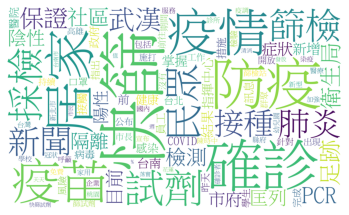

<Figure size 1000x600 with 0 Axes>

In [39]:
def generate_wordcloud(keywords, stopwords, file_path):
    wc = WordCloud(font_path = "./TW-Sung-98_1.ttf",
                   background_color = "white",
                   max_words = 100, stopwords = stopwords,
                   width = 2000, height = 1200)
    wc.generate_from_frequencies(keywords)
    plt.imshow(wc)
    plt.axis("off")
    plt.figure(figsize = (10, 6), dpi = 100)
    plt.show()
    wc.to_file('./文字雲/自主監測_自由.jpg')

x = generate_wordcloud(fdist, stopwords, "./selft_wordcloud1.jpg")